In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json

data = pd.read_csv('train.csv')
data.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.10,0.90,7,286,4,0,1,0,sales,low
1,0.89,0.93,4,249,3,0,0,0,sales,low
2,0.38,0.50,2,132,3,0,1,0,accounting,low
3,0.95,0.71,4,151,4,0,0,0,sales,medium
4,0.84,0.84,5,163,3,0,0,0,technical,low


In [2]:
print data.shape

(11238, 10)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    data.left,
    test_size=0.2,
    random_state=0)

print len(X_train)

8990


In [4]:
#map_range_sl = lambda x : '<=0.37' if x <= 0.37 else ('>0.37 and <=0.51' if x <= 0.51 else ('>0.51 and <=0.64' if x<=0.64 else ('>0.64 and <=0.76' if x<=0.76 else ('>0.76 and <=0.87' if x<=0.87 else '>0.87'))))
map_range_sl = lambda x: '<=0.17' if x<=0.17 else ('0.18 to 0.29' if x <= 0.29 else ('0.30 to 0.39' if x<=0.39 else ('0.40 to 0.46' if x<=0.46 else ('0.47 to 0.53' if x<=0.53 else ('0.54 to 0.6' if x<=0.6 else ('0.61 to 0.67' if x<=0.67 else ('0.68 to 0.74' if x<=0.74 else ('0.75 to 0.8' if x<=0.8 else ('0.81 to 0.87' if x<=0.87 else ('0.88 to 0.94' if x<=0.94 else '>0.94'))))))))))
X_train.satisfaction_level = X_train.satisfaction_level.apply(map_range_sl)
X_test.satisfaction_level = X_test.satisfaction_level.apply(map_range_sl)

# map_range_le = lambda x : '<=0.52' if x <= 0.52 else ('>0.52 and <=0.61' if x <= 0.61 else ('>0.61 and <=0.72' if x<=0.72 else ('>0.72 and <=0.83' if x<=0.83 else ('>0.83 and <=0.91' if x<=0.91 else '>0.91'))))
map_range_le = lambda x: '<=0.44' if x<=0.44 else ('0.45 to 0.51' if x <= 0.51 else ('0.52 to 0.58' if x<=0.58 else ('0.59 to 0.65' if x<=0.65 else ('0.66 to 0.71' if x<=0.71 else ('0.72 to 0.78' if x<=0.78 else ('0.79 to 0.86' if x<=0.86 else ('0.87 to 0.93' if x<=0.93 else '>0.93'))))))) 
X_train.last_evaluation = X_train.last_evaluation.apply(map_range_le)
X_test.last_evaluation = X_test.last_evaluation.apply(map_range_le)

# map_range_np = lambda x : '<=3' if x <=3 else ('>3 and <=6' if x<=6 else '>6')
map_range_np = lambda x: '<=3' if x<=3 else '>3'
X_train.number_project = X_train.number_project.apply(map_range_np)
X_test.number_project = X_test.number_project.apply(map_range_np)

# map_range_amh = lambda x : '<=156' if x <=156 else ('>156 and <=199' if x<=199 else ('>199 and <=245' if x<=245 else '>245'))
map_range_amh = lambda x: '<=173' if x<=173 else ('174 to 229' if x<=229 else '>229')
X_train.average_montly_hours = X_train.average_montly_hours.apply(map_range_amh)
X_test.average_montly_hours = X_test.average_montly_hours.apply(map_range_amh)

map_range_ts = lambda x : '<=3' if x <=3 else ('>3 and <=6' if x<=6 else '>6')
X_train.time_spend_company = X_train.time_spend_company.apply(map_range_ts)
X_test.time_spend_company = X_test.time_spend_company.apply(map_range_ts)

/home/tarunm/.local/lib/python2.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
1994,0.75 to 0.8,0.59 to 0.65,>3,>229,<=3,0,0,0,sales,low
2032,0.68 to 0.74,0.52 to 0.58,>3,<=173,<=3,0,0,0,hr,low
883,0.54 to 0.6,0.45 to 0.51,<=3,<=173,>3 and <=6,0,0,0,support,low
7069,0.47 to 0.53,>0.93,<=3,174 to 229,>3 and <=6,1,0,0,IT,low
10426,0.18 to 0.29,0.79 to 0.86,<=3,174 to 229,>3 and <=6,0,0,0,IT,low


In [6]:
def create_tree_node(value, is_leaf,number,height):
    new_node = dict()
    new_node['value'] = value
    new_node['is_leaf'] = is_leaf
    new_node['children'] = dict()
    new_node['height'] = height
    new_node['number'] = number
    return new_node

In [7]:
def display_tree(t,index):
    print t
    tabs = ''
    for i in range(0,index):
        tabs+='\t'
    print tabs+str(t['value'])
    for c in t['children']:
        i = (index+1)
        display_tree(c,i)

In [8]:
def compute_impurity(pos_ratio,neg_ratio,impurity_function):
    if impurity_function == 'entropy':
        if pos_ratio == 0 or pos_ratio == 1:
            return 0
        else:
            return -((pos_ratio*np.log(pos_ratio)) + (neg_ratio*np.log(neg_ratio)))
    elif impurity_function == 'gini_index':
        return (2*pos_ratio*neg_ratio)
    elif impurity_function == 'misclassification_rate':
        return min(pos_ratio,neg_ratio)
    return 0

In [9]:
def print_tree(curr_data,curr_parent_object,curr_condition, exclude_cols,decision_tree,number_of_nodes,height):
    
    curr_parent_str = curr_parent_object['value']
    if curr_parent_str not in exclude_cols:
        exclude_cols.append(curr_parent_str)
    #print 'Current Parent object : '+str(curr_parent_object)
    #print 'Current Condition : '+str(curr_condition)
    m = len(curr_data)
    G = dict()
    for col in curr_data:
        if col in exclude_cols:
            continue
        I = 0.0
        col_pos = 0
        col_neg = 0
        int_info = 0
        for categ in curr_data[col].unique():
            #print 'col :: '+col+' ; categ :: '+str(categ)
            #print curr_data.groupby([col])['left'].value_counts()[categ]
            pos = 0
            neg = 0
            if 1 in curr_data.groupby([col])['left'].value_counts()[categ]: 
                pos = curr_data.groupby([col])['left'].value_counts()[categ][1]
            if 0 in curr_data.groupby([col])['left'].value_counts()[categ]:
                neg = curr_data.groupby([col])['left'].value_counts()[categ][0]
            col_pos += pos
            col_neg += neg
            pos_ratio = float(pos)/float(pos+neg)
            neg_ratio = float(neg)/float(pos+neg)
            impurity = compute_impurity(pos_ratio,neg_ratio, 'entropy')
            Si_S = float(pos+neg)/float(m) 
            I += Si_S*impurity
            int_info += Si_S*np.log(Si_S)
        col_pos_ratio = float(col_pos)/float(col_pos+col_neg)
        col_neg_ratio = float(col_neg)/float(col_pos+col_neg)
        E = compute_impurity(col_pos_ratio,col_neg_ratio,'entropy')
        G[col] = ((E-I)/(-1*int_info))
    
    if not G:
        if curr_parent_str == 'dummy_parent':
            return decision_tree
        for categ in curr_data[col].unique():
            if 0 in curr_data.groupby([curr_parent_str])['left'].value_counts()[curr_condition] and 1 in curr_data.groupby([curr_parent_str])['left'].value_counts()[curr_condition]:
                if curr_data.groupby([curr_parent_str])['left'].value_counts()[curr_condition][0] > curr_data.groupby([curr_parent_str])['left'].value_counts()[curr_condition][1]:
                    #print 'Left'
                    number_of_nodes += 1
                    new_node = create_tree_node('0',True, number_of_nodes, height)
                    curr_parent_object['children'][curr_condition] = new_node
                else:
                    number_of_nodes += 1
                    new_node = create_tree_node('1',True, number_of_nodes, height)
                    curr_parent_object['children'][curr_condition] = new_node
            elif 0 in curr_data.groupby([curr_parent_str])['left'].value_counts()[curr_condition]:
                number_of_nodes += 1
                new_node = create_tree_node('0',True, number_of_nodes, height)
                curr_parent_object['children'][curr_condition] = new_node
            elif 1 in curr_data.groupby([curr_parent_str])['left'].value_counts()[curr_condition]:
                number_of_nodes += 1
                new_node = create_tree_node('1',True, number_of_nodes, height)
                curr_parent_object['children'][curr_condition] = new_node
            else:
                number_of_nodes += 1
                new_node = create_tree_node('0',True, number_of_nodes, height)
                curr_parent_object['children'][curr_condition] = new_node
        return (decision_tree,number_of_nodes)
    
    max_col = max(G, key=G.get)
    new_node = None
    
    if new_node is None:
        number_of_nodes += 1
        new_node = create_tree_node(max_col,False, number_of_nodes, height)
    if decision_tree is None:
        decision_tree = new_node
    else:
        curr_parent_object['children'][curr_condition] = new_node
    
    
    if new_node['is_leaf']:
        return (decision_tree,number_of_nodes)
    
    
    temp_exclude_cols = exclude_cols[:]
    for cond in curr_data[max_col].unique():
        if 0 in curr_data.groupby([max_col])['left'].value_counts()[cond]:
            neg_count = curr_data.groupby([max_col])['left'].value_counts()[cond][0]
        else:
            neg_count = 0
        if 1 in curr_data.groupby([max_col])['left'].value_counts()[cond]:
            pos_count = curr_data.groupby([max_col])['left'].value_counts()[cond][1]
        else:
            pos_count = 0
        new_node['pos_count'] = pos_count
        new_node['neg_count'] = neg_count
        decision_tree,number_of_nodes = print_tree(curr_data.loc[curr_data[max_col]==cond].copy() , new_node, cond,temp_exclude_cols,decision_tree,number_of_nodes,(height+1))
    
    return (decision_tree,number_of_nodes)

In [10]:
decision_tree = None
dummy_node = dict()
dummy_node['value'] = 'dummy_parent'
decision_tree,number_of_nodes = print_tree(X_train.copy(),dummy_node,'dummy_condition',['left'],decision_tree,0,1)
print number_of_nodes

/home/tarunm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


17108


In [11]:
def validate_row(row,tree_node,max_num):
    if tree_node['is_leaf']:
        if row['left'] == 1 and tree_node['value'] == '1':
            #true positive
            return 2
        elif row['left'] == 1 and tree_node['value'] == '0':
            #false negative
            return -1
        elif row['left'] == 0 and tree_node['value'] == '1':
            #false positive
            return 0
        elif row['left'] == 0 and tree_node['value'] == '0':
            #true negative
            return 1
    if tree_node['number'] >= max_num:
        pc = tree_node['pos_count']
        nc = tree_node['neg_count']
        if pc <= nc and row['left']==1:
            #false negative
            return -1
        elif pc<=nc and row['left']==0:
            #true negative
            return 1
        elif row['left'] == 1:
            #true positive
            return 2
        else:
            #false positive
            return 0
            
    key = tree_node['value']
    val = row[key]
    if val not in tree_node['children']:
        #error considered as true negative
        return 1
    else:
        return validate_row(row,tree_node['children'][val],max_num)

In [12]:
def get_accuracy(X,tree,max_num):
    m = len(X)
    hits = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for index,row in X.iterrows():
        verdict = validate_row(row,tree,max_num)
        if verdict == -1:
            fn += 1
        elif verdict == 0:
            fp += 1
        elif verdict == 1:
            hits += 1
            tn += 1
        elif verdict == 2:
            hits += 1
            tp += 1
    
    accuracy = float(hits)/float(m)
    return accuracy

In [ ]:
heights = list()
train_accuracies = list()
for h in range(1,11):
    acc = get_accuracy(X_train,decision_tree,h)
    heights.append(h)
    train_accuracies.append(acc)

test_accuracies = list()
for h in range(1,11):
    acc = get_accuracy(X_test,decision_tree,h)
    test_accuracies.append(acc)
# print train_accuracies
df = pd.DataFrame({'Train Performance': train_accuracies,'Test Performance': test_accuracies}, index=heights)
lines = df.plot.line()

In [16]:
numbers = list()
train_accuracies = list()
for n in range(1,17108,100):
    acc = get_accuracy(X_train,decision_tree,n)
    numbers.append(n)
    train_accuracies.append(acc)

test_accuracies = list()
for n in range(1,17108,100):
    acc = get_accuracy(X_test,decision_tree,n)
    test_accuracies.append(acc)
# print train_accuracies
print numbers
print
print
print train_accuracies
print
print
print test_accuracies

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501, 3601, 3701, 3801, 3901, 4001, 4101, 4201, 4301, 4401, 4501, 4601, 4701, 4801, 4901, 5001, 5101, 5201, 5301, 5401, 5501, 5601, 5701, 5801, 5901, 6001, 6101, 6201, 6301, 6401, 6501, 6601, 6701, 6801, 6901, 7001, 7101, 7201, 7301, 7401, 7501, 7601, 7701, 7801, 7901, 8001, 8101, 8201, 8301, 8401, 8501, 8601, 8701, 8801, 8901, 9001, 9101, 9201, 9301, 9401, 9501, 9601, 9701, 9801, 9901, 10001, 10101, 10201, 10301, 10401, 10501, 10601, 10701, 10801, 10901, 11001, 11101, 11201, 11301, 11401, 11501, 11601, 11701, 11801, 11901, 12001, 12101, 12201, 12301, 12401, 12501, 12601, 12701, 12801, 12901, 13001, 13101, 13201, 13301, 13401, 13501, 13601, 13701, 13801, 13901, 14001, 14101, 14201, 14301, 14401, 14501, 14601, 14701, 14801, 14901, 15001, 15101, 15201, 15301, 15401, 15501, 15601, 15701, 15801

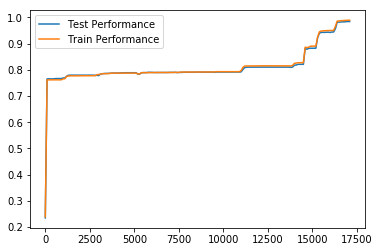

In [17]:
nums = [1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501, 3601, 3701, 3801, 3901, 4001, 4101, 4201, 4301, 4401, 4501, 4601, 4701, 4801, 4901, 5001, 5101, 5201, 5301, 5401, 5501, 5601, 5701, 5801, 5901, 6001, 6101, 6201, 6301, 6401, 6501, 6601, 6701, 6801, 6901, 7001, 7101, 7201, 7301, 7401, 7501, 7601, 7701, 7801, 7901, 8001, 8101, 8201, 8301, 8401, 8501, 8601, 8701, 8801, 8901, 9001, 9101, 9201, 9301, 9401, 9501, 9601, 9701, 9801, 9901, 10001, 10101, 10201, 10301, 10401, 10501, 10601, 10701, 10801, 10901, 11001, 11101, 11201, 11301, 11401, 11501, 11601, 11701, 11801, 11901, 12001, 12101, 12201, 12301, 12401, 12501, 12601, 12701, 12801, 12901, 13001, 13101, 13201, 13301, 13401, 13501, 13601, 13701, 13801, 13901, 14001, 14101, 14201, 14301, 14401, 14501, 14601, 14701, 14801, 14901, 15001, 15101, 15201, 15301, 15401, 15501, 15601, 15701, 15801, 15901, 16001, 16101, 16201, 16301, 16401, 16501, 16601, 16701, 16801, 16901, 17001, 17101]
tr_acc = [0.23882091212458287, 0.7612903225806451, 0.7615127919911012, 0.7616240266963292, 0.7616240266963292, 0.7616240266963292, 0.7616240266963292, 0.7616240266963292, 0.7616240266963292, 0.7616240266963292, 0.7650723025583982, 0.7657397107897664, 0.774860956618465, 0.7761957730812014, 0.7767519466073415, 0.7768631813125695, 0.7768631813125695, 0.7768631813125695, 0.7769744160177976, 0.7769744160177976, 0.7769744160177976, 0.7769744160177976, 0.7769744160177976, 0.7767519466073415, 0.7770856507230256, 0.7770856507230256, 0.7771968854282536, 0.7773081201334816, 0.7774193548387097, 0.7812013348164627, 0.7818687430478309, 0.7830923248053393, 0.7849833147942158, 0.7850945494994438, 0.7853170189098999, 0.7853170189098999, 0.78587319243604, 0.7868743047830923, 0.7868743047830923, 0.7868743047830923, 0.7868743047830923, 0.7869855394883204, 0.7872080088987764, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7873192436040044, 0.7840934371523915, 0.7842046718576196, 0.7888765294771969, 0.7889877641824249, 0.7889877641824249, 0.7889877641824249, 0.7889877641824249, 0.789098998887653, 0.789098998887653, 0.789210233592881, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7895439377085651, 0.7896551724137931, 0.7896551724137931, 0.7904338153503894, 0.7896551724137931, 0.7897664071190211, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7911012235817575, 0.7913236929922136, 0.7913236929922136, 0.7913236929922136, 0.7913236929922136, 0.7913236929922136, 0.7914349276974416, 0.7915461624026696, 0.7915461624026696, 0.7915461624026696, 0.7916573971078976, 0.7913236929922136, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.79265850945495, 0.7965517241379311, 0.8088987764182425, 0.814238042269188, 0.8143492769744161, 0.8147942157953282, 0.8149054505005562, 0.8149054505005562, 0.8149054505005562, 0.8149054505005562, 0.8149054505005562, 0.8149054505005562, 0.8150166852057842, 0.8150166852057842, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8151279199110122, 0.8147942157953282, 0.8167964404894327, 0.8245828698553949, 0.8255839822024471, 0.8268075639599555, 0.8270300333704116, 0.8271412680756396, 0.8271412680756396, 0.885650723025584, 0.8846496106785317, 0.8859844271412681, 0.8898776418242491, 0.8902113459399332, 0.8902113459399332, 0.8897664071190211, 0.924694104560623, 0.9444938820912124, 0.9478309232480534, 0.9484983314794215, 0.9489432703003337, 0.9493882091212458, 0.9496106785317019, 0.9496106785317019, 0.949833147942158, 0.950166852057842, 0.9655172413793104, 0.985539488320356, 0.9862068965517241, 0.9866518353726362, 0.9875417130144605, 0.9879866518353726, 0.9884315906562847, 0.9888765294771968, 0.9888765294771968]
te_acc = [0.23487544483985764, 0.7651245551601423, 0.7655693950177936, 0.7651245551601423, 0.7651245551601423, 0.7655693950177936, 0.766459074733096, 0.766459074733096, 0.766459074733096, 0.766459074733096, 0.7686832740213523, 0.7686832740213523, 0.775355871886121, 0.7789145907473309, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7793594306049823, 0.7784697508896797, 0.7789145907473309, 0.7775800711743772, 0.7833629893238434, 0.7846975088967971, 0.7855871886120996, 0.7860320284697508, 0.7860320284697508, 0.7864768683274022, 0.7869217081850534, 0.7873665480427047, 0.7873665480427047, 0.7873665480427047, 0.7873665480427047, 0.7878113879003559, 0.7882562277580071, 0.7882562277580071, 0.7887010676156584, 0.7887010676156584, 0.7887010676156584, 0.7887010676156584, 0.7887010676156584, 0.7887010676156584, 0.7887010676156584, 0.7833629893238434, 0.7833629893238434, 0.7882562277580071, 0.7891459074733096, 0.7891459074733096, 0.7891459074733096, 0.7904804270462633, 0.7900355871886121, 0.7900355871886121, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7895907473309609, 0.7900355871886121, 0.7900355871886121, 0.7900355871886121, 0.7900355871886121, 0.7895907473309609, 0.7895907473309609, 0.7900355871886121, 0.7900355871886121, 0.7904804270462633, 0.7904804270462633, 0.7904804270462633, 0.7904804270462633, 0.7904804270462633, 0.7904804270462633, 0.7904804270462633, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7909252669039146, 0.7900355871886121, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.7913701067615658, 0.791814946619217, 0.800711743772242, 0.8082740213523132, 0.8096085409252669, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8100533807829181, 0.8091637010676157, 0.8104982206405694, 0.8176156583629893, 0.8180604982206405, 0.8207295373665481, 0.8207295373665481, 0.8207295373665481, 0.8207295373665481, 0.8816725978647687, 0.8781138790035588, 0.8816725978647687, 0.8821174377224199, 0.8821174377224199, 0.8821174377224199, 0.8821174377224199, 0.922153024911032, 0.9395017793594306, 0.9426156583629893, 0.9426156583629893, 0.9426156583629893, 0.9430604982206405, 0.9435053380782918, 0.9421708185053381, 0.943950177935943, 0.943950177935943, 0.9564056939501779, 0.9813167259786477, 0.9817615658362989, 0.9822064056939501, 0.9826512455516014, 0.9826512455516014, 0.983540925266904, 0.9839857651245552, 0.9839857651245552]
df = pd.DataFrame({'Train Performance': tr_acc,'Test Performance': te_acc}, index=nums)
lines = df.plot.line()